<a href="https://colab.research.google.com/github/Scarfaced007/CNN-DL/blob/main/DL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.9 * len(full_train_set))
val_size = len(full_train_set) - train_size

train_set, val_set = torch.utils.data.random_split(full_train_set, [train_size, val_size],
                                                   generator=torch.Generator().manual_seed(SEED))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

print(f"Data Split: {len(train_set)} Train, {len(val_set)} Val, {len(test_set)} Test")

100%|██████████| 170M/170M [00:19<00:00, 8.97MB/s]


Data Split: 45000 Train, 5000 Val, 10000 Test


In [ ]:
model = torchvision.models.resnet18(weights=None)

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
epochs = 35
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
print("Starting Training...")
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    val_acc = 100. * val_correct / val_total

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f"\nFINAL TEST ACCURACY: {100. * test_correct / test_total:.2f}%")

Starting Training...
Epoch 1/35 | Loss: 1.9212 | Train Acc: 32.32% | Val Acc: 41.70%
Epoch 2/35 | Loss: 1.3442 | Train Acc: 50.70% | Val Acc: 53.26%
Epoch 3/35 | Loss: 1.0320 | Train Acc: 63.09% | Val Acc: 66.96%
Epoch 4/35 | Loss: 0.7753 | Train Acc: 72.63% | Val Acc: 73.22%
Epoch 5/35 | Loss: 0.6079 | Train Acc: 78.80% | Val Acc: 74.86%
Epoch 6/35 | Loss: 0.5023 | Train Acc: 82.42% | Val Acc: 77.56%
Epoch 7/35 | Loss: 0.4275 | Train Acc: 84.98% | Val Acc: 73.94%
Epoch 8/35 | Loss: 0.3566 | Train Acc: 87.60% | Val Acc: 78.50%
Epoch 9/35 | Loss: 0.3172 | Train Acc: 88.80% | Val Acc: 76.12%
Epoch 10/35 | Loss: 0.2815 | Train Acc: 90.28% | Val Acc: 74.14%
Epoch 11/35 | Loss: 0.2478 | Train Acc: 91.44% | Val Acc: 79.54%
Epoch 12/35 | Loss: 0.2232 | Train Acc: 92.18% | Val Acc: 77.12%
Epoch 13/35 | Loss: 0.2016 | Train Acc: 93.00% | Val Acc: 77.94%
Epoch 14/35 | Loss: 0.1850 | Train Acc: 93.46% | Val Acc: 79.76%
Epoch 15/35 | Loss: 0.1755 | Train Acc: 93.84% | Val Acc: 78.02%
Epoch 16/35 |

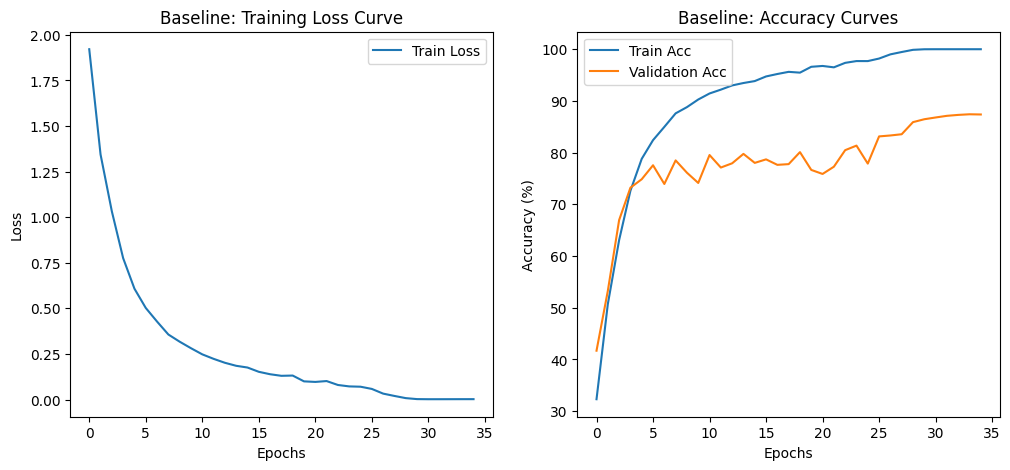

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Baseline: Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.title('Baseline: Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Searching for high-confidence failures...
Found 5 high-confidence failures:


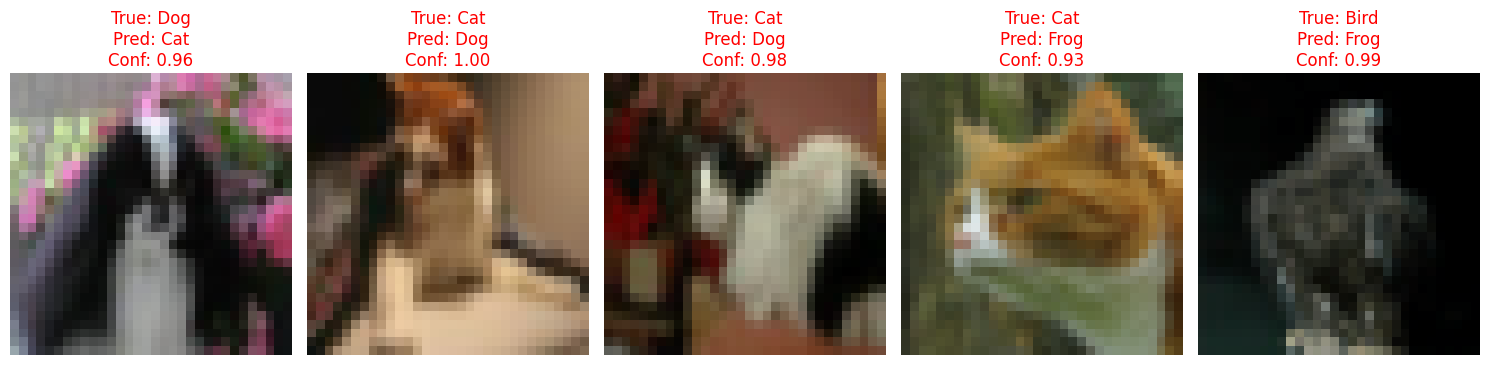

In [ ]:
import torch.nn.functional as F
import numpy as np

def get_high_confidence_failures(model, loader, threshold=0.85, num_images=5):
    """
    Finds images where the model is incorrect but predicts with high confidence.
    """
    model.eval()
    failures = []
    classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(device)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = F.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            wrong_indices = (preds != labels) & (conf > threshold)
            failure_idx = torch.nonzero(wrong_indices, as_tuple=True)[0]

            if len(failure_idx) > 0:
                for idx in failure_idx:
                    if len(failures) >= num_images:
                        return failures

                    img = inputs[idx] * std + mean
                    img = torch.clamp(img, 0, 1)

                    failures.append({
                        'image': img.cpu(),
                        'true': classes[labels[idx].item()],
                        'pred': classes[preds[idx].item()],
                        'conf': conf[idx].item()
                    })
    return failures

def plot_failures(failures):
    """
    Plots the collected failure cases.
    """
    plt.figure(figsize=(15, 4))
    for i, fail in enumerate(failures):
        ax = plt.subplot(1, len(failures), i + 1)

        img_np = fail['image'].permute(1, 2, 0).numpy()

        plt.imshow(img_np)
        plt.title(f"True: {fail['true']}\nPred: {fail['pred']}\nConf: {fail['conf']:.2f}",
                  color='red', fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Searching for high-confidence failures...")
failure_cases = get_high_confidence_failures(model, test_loader, threshold=0.90, num_images=5)

if len(failure_cases) > 0:
    print(f"Found {len(failure_cases)} high-confidence failures:")
    plot_failures(failure_cases)
else:
    print("No failures found above the threshold. Your model might be too accurate or calibrated!")

Visualizing Failure Cases with Grad-CAM...


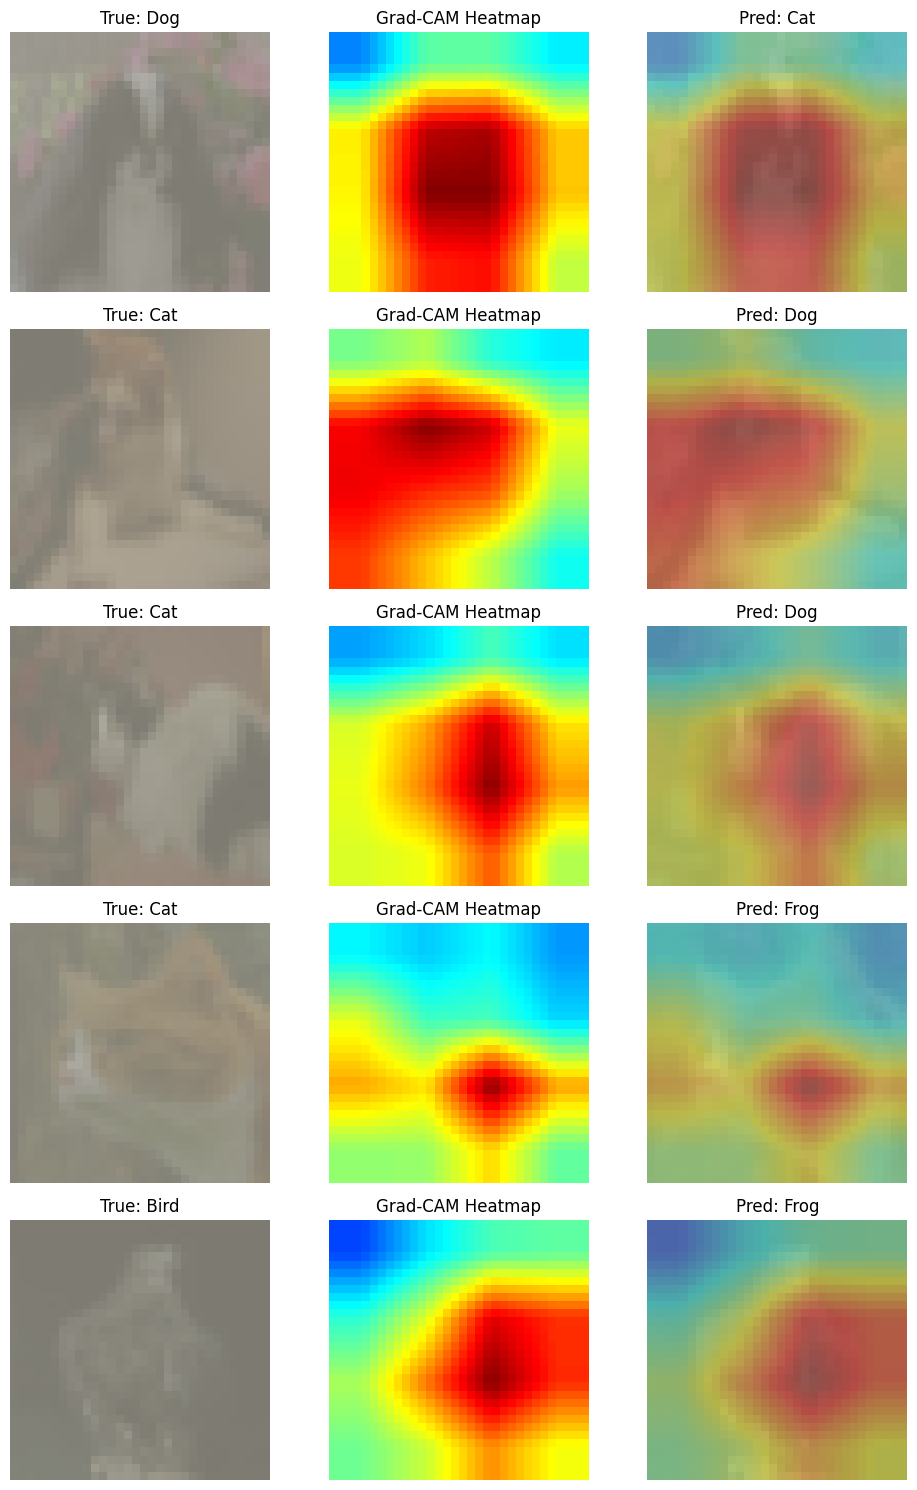

In [ ]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().detach()
        heatmap = torch.maximum(heatmap, torch.tensor(0.0))
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

def visualize_failures_with_gradcam(model, failure_cases):
    target_layer = model.layer4[-1]
    grad_cam = GradCAM(model, target_layer)

    plt.figure(figsize=(10, len(failure_cases) * 3))

    for i, fail in enumerate(failure_cases):
        img_tensor = fail['image'].unsqueeze(0).to(device)

        heatmap = grad_cam(img_tensor)
        heatmap = cv2.resize(heatmap, (32, 32))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(device)
        orig_img = fail['image'].to(device) * std + mean
        orig_img = torch.clamp(orig_img, 0, 1).cpu().permute(1, 2, 0).numpy()
        orig_img_uint8 = np.uint8(255 * orig_img)

        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        superimposed = cv2.addWeighted(orig_img_uint8, 0.6, heatmap, 0.4, 0)

        plt.subplot(len(failure_cases), 3, i*3 + 1)
        plt.imshow(orig_img)
        plt.title(f"True: {fail['true']}")
        plt.axis('off')

        plt.subplot(len(failure_cases), 3, i*3 + 2)
        plt.imshow(heatmap)
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')

        plt.subplot(len(failure_cases), 3, i*3 + 3)
        plt.imshow(superimposed)
        plt.title(f"Pred: {fail['pred']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing Failure Cases with Grad-CAM...")
visualize_failures_with_gradcam(model, failure_cases)

Initializing Augmented Model...
Starting Training with Data Augmentation...
Epoch 1/35 | Aug Train Acc: 29.68% | Aug Test Acc: 38.97%
Epoch 2/35 | Aug Train Acc: 48.35% | Aug Test Acc: 54.38%
Epoch 3/35 | Aug Train Acc: 59.55% | Aug Test Acc: 57.19%
Epoch 4/35 | Aug Train Acc: 67.66% | Aug Test Acc: 68.02%
Epoch 5/35 | Aug Train Acc: 73.96% | Aug Test Acc: 72.28%
Epoch 6/35 | Aug Train Acc: 78.15% | Aug Test Acc: 77.26%
Epoch 7/35 | Aug Train Acc: 80.32% | Aug Test Acc: 76.34%
Epoch 8/35 | Aug Train Acc: 81.79% | Aug Test Acc: 76.22%
Epoch 9/35 | Aug Train Acc: 82.75% | Aug Test Acc: 80.41%
Epoch 10/35 | Aug Train Acc: 83.71% | Aug Test Acc: 68.10%
Epoch 11/35 | Aug Train Acc: 84.39% | Aug Test Acc: 82.09%
Epoch 12/35 | Aug Train Acc: 85.10% | Aug Test Acc: 78.09%
Epoch 13/35 | Aug Train Acc: 85.66% | Aug Test Acc: 83.73%
Epoch 14/35 | Aug Train Acc: 86.22% | Aug Test Acc: 77.80%
Epoch 15/35 | Aug Train Acc: 86.48% | Aug Test Acc: 82.67%
Epoch 16/35 | Aug Train Acc: 87.46% | Aug Test A

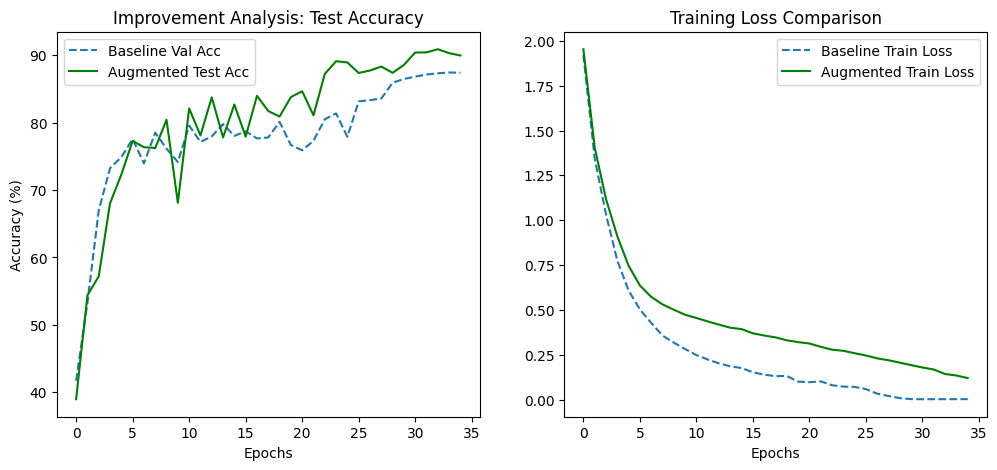

In [ ]:
transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_aug)
train_loader_aug = torch.utils.data.DataLoader(train_set_aug, batch_size=128, shuffle=True)

print("Initializing Augmented Model...")
model_aug = torchvision.models.resnet18(weights=None)
model_aug.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_aug.maxpool = nn.Identity()
model_aug.fc = nn.Linear(512, 10)
model_aug = model_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler_aug = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aug, T_max=50)

epochs = 35
history_aug = {'train_loss': [], 'train_acc': [], 'test_acc': []}

print("Starting Training with Data Augmentation...")
for epoch in range(epochs):
    model_aug.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_aug.zero_grad()
        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_aug.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler_aug.step()

    model_aug.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_aug(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader_aug)
    train_acc = 100. * correct / total
    test_acc = 100. * test_correct / test_total

    history_aug['train_loss'].append(train_loss)
    history_aug['train_acc'].append(train_acc)
    history_aug['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Aug Train Acc: {train_acc:.2f}% | Aug Test Acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['val_acc'], label='Baseline Val Acc', linestyle='--')
plt.plot(history_aug['test_acc'], label='Augmented Test Acc', color='green')
plt.title('Improvement Analysis: Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Baseline Train Loss', linestyle='--')
plt.plot(history_aug['train_loss'], label='Augmented Train Loss', color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Re-evaluating 5 failure cases on the Augmented Model...



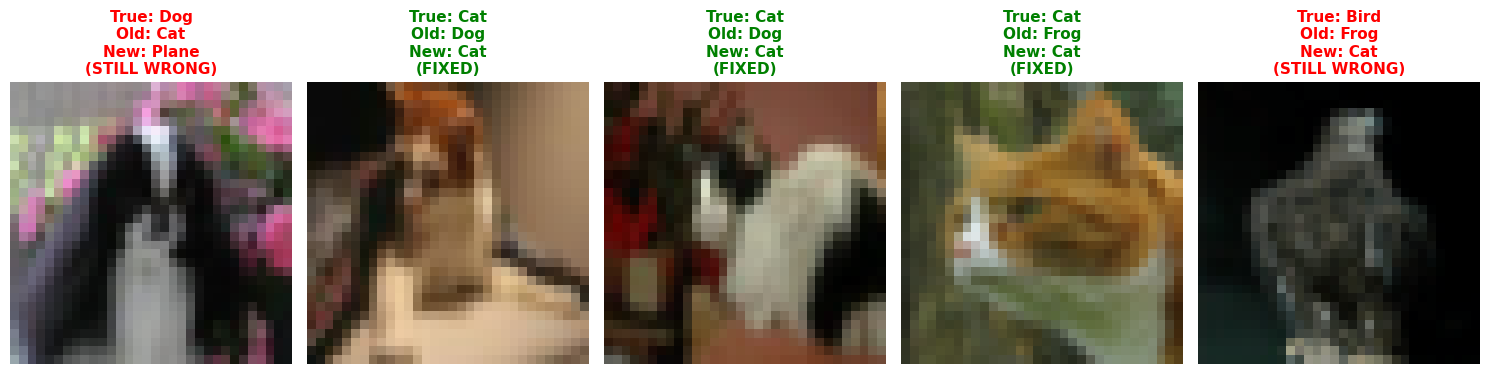

In [ ]:
def check_failures_on_new_model(model_aug, failure_cases):
    model_aug.eval()
    print(f"Re-evaluating {len(failure_cases)} failure cases on the Augmented Model...\n")

    results = []

    with torch.no_grad():
        for i, fail in enumerate(failure_cases):
            img_tensor = fail['image'].unsqueeze(0).to(device)

            outputs = model_aug(img_tensor)
            probs = F.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probs, dim=1)

            classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer',
                       'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
            new_pred = classes[pred_idx.item()]
            new_conf = conf.item()

            status = "FIXED" if new_pred == fail['true'] else "STILL WRONG"

            results.append((fail['image'], fail['true'], fail['pred'], new_pred, new_conf, status))

    plt.figure(figsize=(15, 6))
    for i, (img, true_lbl, old_pred, new_pred, new_conf, status) in enumerate(results):
        ax = plt.subplot(1, len(results), i + 1)

        img_np = img.permute(1, 2, 0).numpy()

        title_color = 'green' if status == "FIXED" else 'red'

        plt.imshow(img_np)
        plt.title(f"True: {true_lbl}\nOld: {old_pred}\nNew: {new_pred}\n({status})",
                  color=title_color, fontsize=11, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

check_failures_on_new_model(model_aug, failure_cases)